In [ ]:
#This notebook retrieves images from Microsoft's planetary computer based on user input GPS coordinates and satellite name

In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

The following data is from NOAA monitoring in western Lake Erie (https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/). It contains data on microcystin (the toxin produced by cyanobacteria) concentration as well as some other related parameters. I have found some other easily accesable data sets similar to this one but for other inland waters in the US. If I were to make a labeled data set, I would probably start with a simple presence/absence target value. Alternatively, I could develop a few classes (absent, low, medium, high) based on observed microsystin values.

In [2]:
# import cyanobacteria data 
!wget https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/2022_WLE_Weekly_Datashare_CSV.csv

--2023-04-19 14:05:09--  https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/2022_WLE_Weekly_Datashare_CSV.csv
Resolving www.glerl.noaa.gov (www.glerl.noaa.gov)... 192.94.173.55, 2610:20:900d:4010::55
Connecting to www.glerl.noaa.gov (www.glerl.noaa.gov)|192.94.173.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41254 (40K) [text/csv]
Saving to: ‘2022_WLE_Weekly_Datashare_CSV.csv’

2022_WLE_Weekly_Dat 100%[===================>]  40.29K  --.-KB/s    in 0.1s    

2023-04-19 14:05:09 (378 KB/s) - ‘2022_WLE_Weekly_Datashare_CSV.csv’ saved [41254/41254]



In [25]:
df = pd.read_csv('2022_WLE_Weekly_Datashare_CSV.csv')
#df.head()
#df.columns
df.shape

(234, 26)

In [26]:
df = df[['Date', 'Lat_deg', 'Long_deg', 'Dissolved_Microcystin_ugL-1']]
df = df.dropna()
df.Date = pd.to_datetime(df.Date)
#print(df.shape)
print(df.head(1))
#print(df.dtypes)

        Date  Lat_deg  Long_deg Dissolved_Microcystin_ugL-1
0 2022-04-25  41.7621 -83.33005                        0.25


In [27]:
# adding a column for presence or absence
micro_list = df['Dissolved_Microcystin_ugL-1'].tolist()
pres_abs = []
for val in micro_list:
  if val == 'bdl':
    pres = 0
  else:
    pres = 1
  pres_abs.append(pres)

df['label'] = pres_abs

df.head(1)

,Date,Lat_deg,Long_deg,Dissolved_Microcystin_ugL-1,label
0,2022-04-25,41.7621,-83.33005,0.25,1


In [6]:
df['label'].value_counts() 

1    133
0     19
Name: label, dtype: int64

In [7]:
!pip install --upgrade geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.0 MB/s eta 0:00:00


In [ ]:
#The following code has been adapted from the following blog post:
#https://drivendata.co/blog/tick-tick-bloom-benchmark

# by Katie Wetstone in December 2022

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map 
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

(25.0, 50.0)

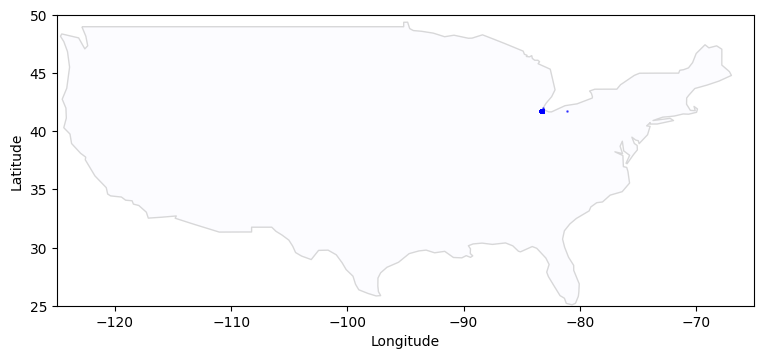

In [9]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the  data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)

geometry = [Point(xy) for xy in zip(df["Long_deg"], df["Lat_deg"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", alpha=0.6)


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])

In [10]:
!pip install planetary_computer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 5.1 MB/s eta 0:00:00


In [11]:

# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)


In [12]:

example_row = df.iloc[0]
example_row

Date                                 2022-04-25 00:00:00
Lat_deg                                          41.7621
Long_deg                                       -83.33005
Dissolved_Microcystin_ugL-1                         0.25
label                                                  1
geometry                       POINT (-83.33005 41.7621)
Name: 0, dtype: object

In [13]:
import geopy.distance as distance
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=200):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.Lat_deg, example_row.Long_deg, meter_buffer=200)
bbox

[-83.33245504173051, 41.76029931184739, -83.32764495826949, 41.76390068758629]

In [14]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"
    return date_range


date_range = get_date_range(example_row.Date)
date_range

'2022-04-10/2022-04-25'

In [15]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

12

In [16]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.Lat_deg)
    & (item_details.max_lat > example_row.Lat_deg)
    & (item_details.min_long < example_row.Long_deg)
    & (item_details.max_long > example_row.Long_deg)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 12 returned to 12 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
11,2022-04-10,landsat-8,True,"[-83.65884741, 40.65990501, -80.78935659, 42.8..."
8,2022-04-14,Sentinel-2B,True,"[-83.43118, 41.43883629, -82.08002, 42.44744303]"
9,2022-04-14,Sentinel-2B,True,"[-84.60571, 41.40772619, -83.27698, 42.42936087]"
10,2022-04-14,Sentinel-2B,True,"[-84.60654, 41.40403475, -83.23688, 42.42173351]"
7,2022-04-17,landsat-8,True,"[-85.21730731, 40.6300051, -82.27335664, 42.86..."
4,2022-04-19,Sentinel-2A,True,"[-83.43118, 41.51035213, -82.0809, 42.44744303]"
5,2022-04-19,Sentinel-2A,True,"[-84.52646, 41.74764295, -83.287964, 42.42936087]"
6,2022-04-19,Sentinel-2A,True,"[-84.60654, 41.40403475, -83.26428, 42.10966046]"
1,2022-04-24,Sentinel-2B,True,"[-83.43118, 41.43883629, -82.08002, 42.44744303]"
2,2022-04-24,Sentinel-2B,True,"[-84.60495, 41.40772619, -83.27698, 42.42936087]"


In [17]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2022-04-24
platform                                                       Sentinel-2B
min_long                                                         -83.43118
max_long                                                         -82.08002
min_lat                                                          41.438836
max_lat                                                          42.447443
bbox                      [-83.43118, 41.43883629, -82.08002, 42.44744303]
item_obj                 <Item id=S2B_MSIL2A_20220424T161829_R040_T17TL...
contains_sample_point                                                 True
Name: 1, dtype: object

In [18]:
item = best_item.item_obj
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [19]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 58.2 MB/s eta 0:00:00


In [20]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [21]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [22]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [23]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.Lat_deg, example_row.Long_deg, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)
print(zoomed_img_array.shape)
zoomed_img_array[0]



(3, 617, 617)


array([[230, 227, 226, ..., 128, 127, 127],
       [229, 227, 230, ..., 125, 125, 125],
       [227, 228, 229, ..., 124, 125, 124],
       ...,
       [181, 179, 180, ..., 189, 190, 190],
       [178, 179, 179, ..., 192, 192, 192],
       [178, 179, 179, ..., 192, 191, 193]], dtype=uint8)

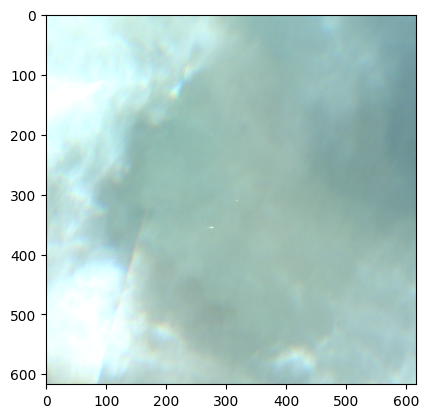

In [24]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))